**IMPORTING REQUIRED LIBRARIES**

In [26]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

In [27]:
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
yf.pdr_override()

#### TESTING FOR COINTEGRATION

The steps in the cointegration test procdure:

1. Test for a unit root in each component series $y_{t}$ individually, using the univariate unit root tests, say ADF, PP test.
2. If the unit root cannot be rejected, then the next step is to test cointegration among the components, i.e., to test whether $\alpha Y_{t}$ is I(0).



**FINDING COINTEGRATED PAIRS**

In [28]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [29]:
start = datetime.datetime(2017, 1, 1)
end = datetime.datetime(2024, 1, 1)

tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']


df = pdr.get_data_yahoo(tickers, start, end)['Close']
df.tail()

[*********************100%%**********************]  11 of 11 completed


Ticker,AAPL,ADBE,AMD,EBAY,HPQ,IBM,JNPR,MSFT,ORCL,QCOM,SPY
Date,,,,,,,,,,,
2023-12-22,193.600006,598.750000,139.600006,43.820000,30.18,162.139999,29.450001,374.579987,106.199997,143.490005,473.649994
2023-12-26,193.050003,598.260010,143.410004,43.480000,30.41,163.210007,29.590000,374.660004,106.190002,145.460007,475.649994
2023-12-27,193.149994,596.080017,146.070007,43.380001,30.24,163.460007,29.440001,374.070007,105.940002,145.720001,476.510010
2023-12-28,193.580002,595.520020,148.759995,43.470001,30.18,163.750000,29.510000,375.279999,106.250000,145.860001,476.690002
2023-12-29,192.529999,596.599976,147.410004,43.619999,30.09,163.550003,29.480000,376.040009,105.430000,144.630005,475.309998


[('AMD', 'MSFT'), ('AMD', 'SPY'), ('IBM', 'JNPR'), ('IBM', 'ORCL'), ('IBM', 'QCOM'), ('IBM', 'SPY')]


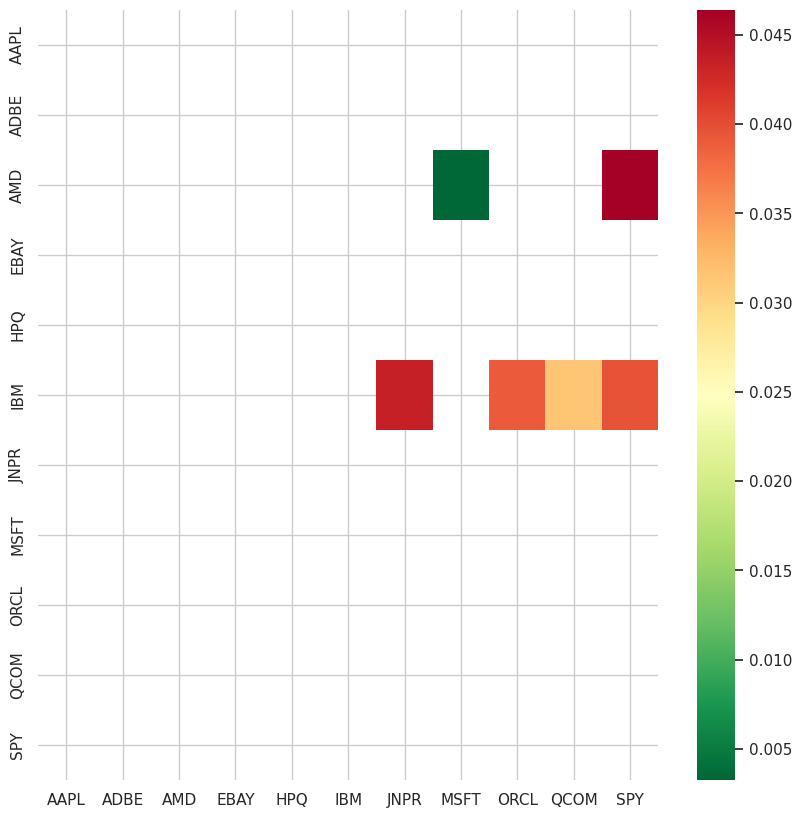

In [30]:
scores, pvalues, pairs = find_cointegrated_pairs(df)
import seaborn
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=df.columns, yticklabels=df.columns, cmap='RdYlGn_r'
                , mask = (pvalues >= 0.05)
                )
print(pairs)
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap

Our algorithm listed a pairs that is cointegrated: AMD/SPY. We can analyze their price patterns to make sure there is nothing weird going on.

In [31]:
S1 = df['AMD']
S2 = df['SPY']

score, pvalue, _ = coint(S1, S2)
pvalue
#pvalue should be less than 0.05

0.04641246645349544

**CALCULATING THE SPREAD USING LINEAR REGRESSION**

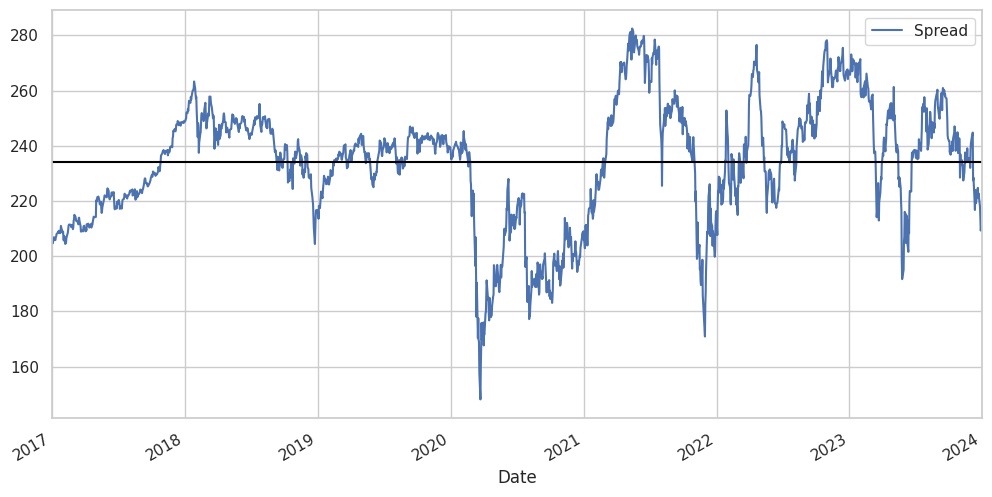

In [32]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['AMD']
b = results.params['AMD']

spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2017-01-01', '2024-01-01')
plt.legend(['Spread']);

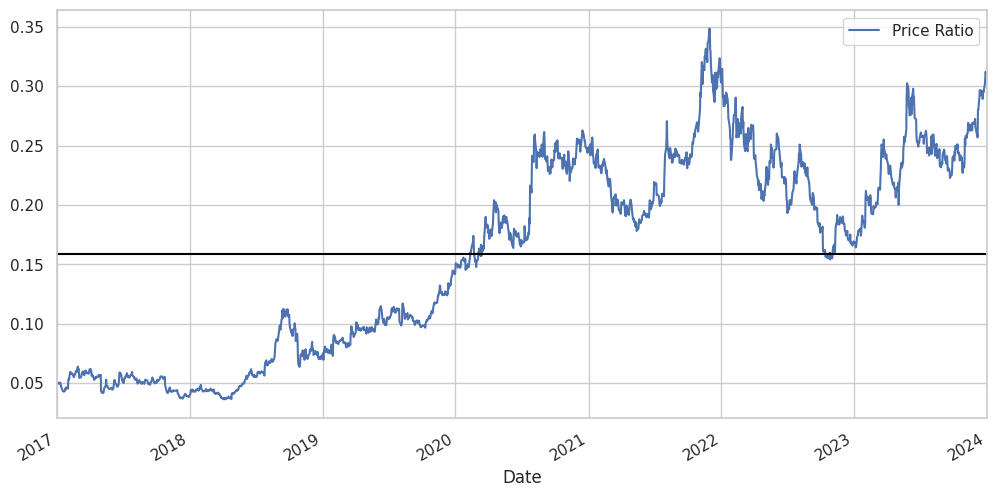

In [33]:
ratio = S1/S2
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2017-01-01', '2024-01-01')
plt.legend(['Price Ratio']);

**CALCULATING Z-SCORE**

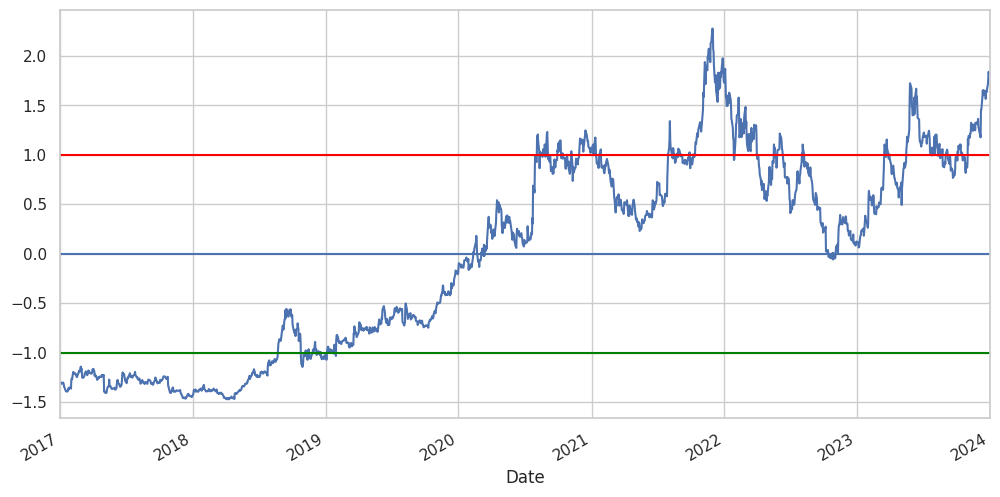

In [34]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(ratio).plot(figsize=(12,6))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2017-01-01', '2024-01-01')
plt.show()

**TEST TRAIN SPLIT**

In [35]:
ratios = df['AMD'] / df['SPY']
print(len(ratios) * .70 )

1232.0


In [36]:
train = ratios[:1232]
test = ratios[1232:]

#### FEATURE ENGINEERING

We need to find out what features are actually important in determining the direction of the ratio moves. Knowing that the ratios always eventually revert back to the mean, maybe the moving averages and metrics related to the mean will be important.

Let's try using these features:

* 60 day Moving Average of Ratio
* 5 day Moving Average of Ratio
* 60 day Standard Deviation
* z score

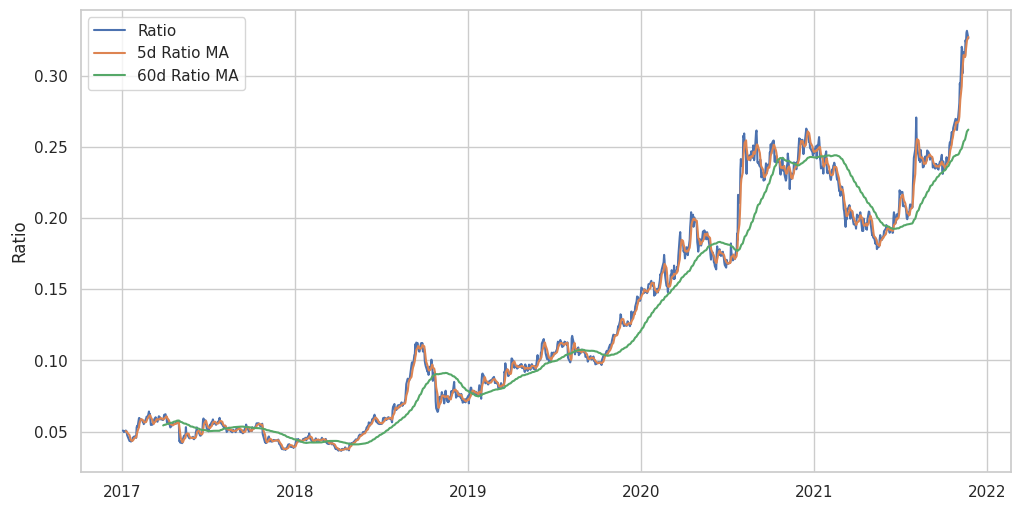

In [37]:
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

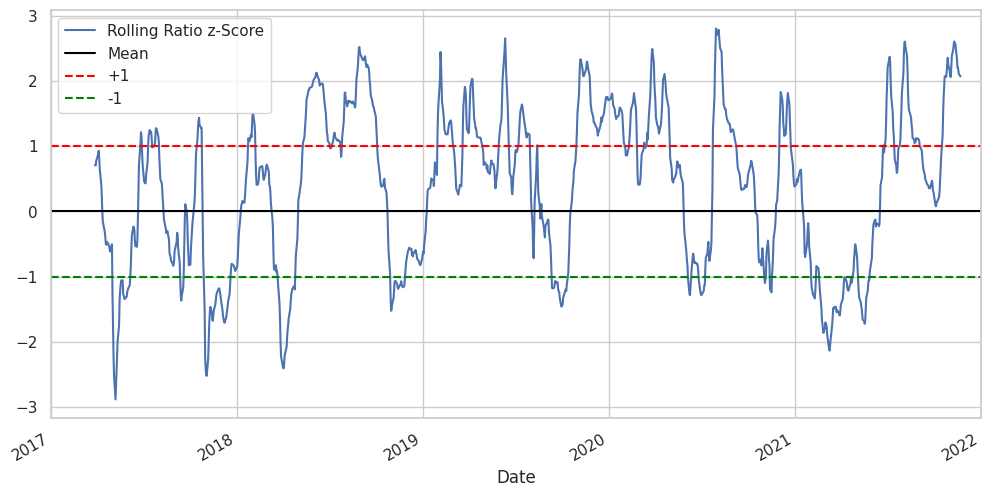

In [38]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.xlim('2017-01-01', '2022-01-01')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

#### BUYING AND SELLING CONDITIONS

A standard normal distribution has a mean of 0 and a standard deviation 1. Looking at the plot, it's pretty clear that if the time series moves 1 standard deviation beyond the mean, it tends to revert back towards the mean. Using these models, we can create the following trading signals:

* Buy(1) whenever the z-score is below -1, meaning we expect the ratio to increase.
* Sell(-1) whenever the z-score is above 1, meaning we expect the ratio to decrease.

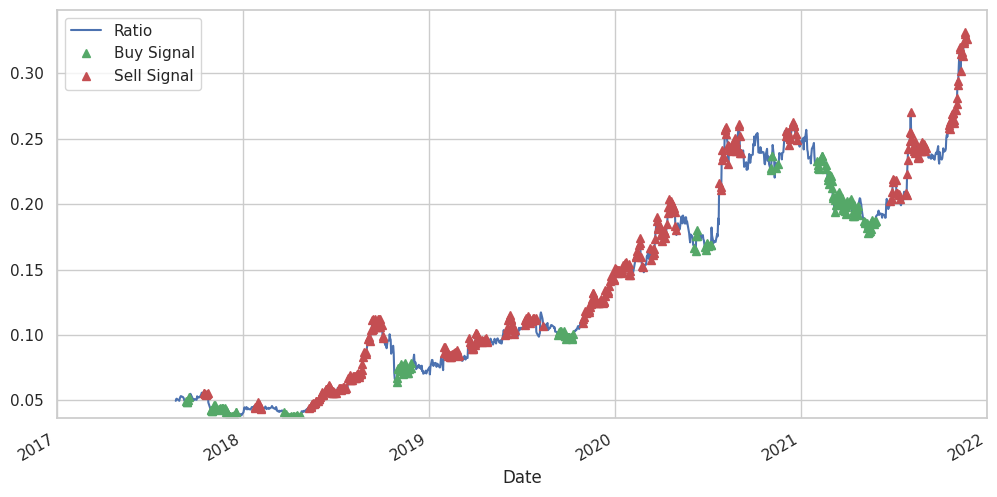

In [39]:
plt.figure(figsize=(12,6))

train[160:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.xlim('2017-01-01','2022-01-01')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

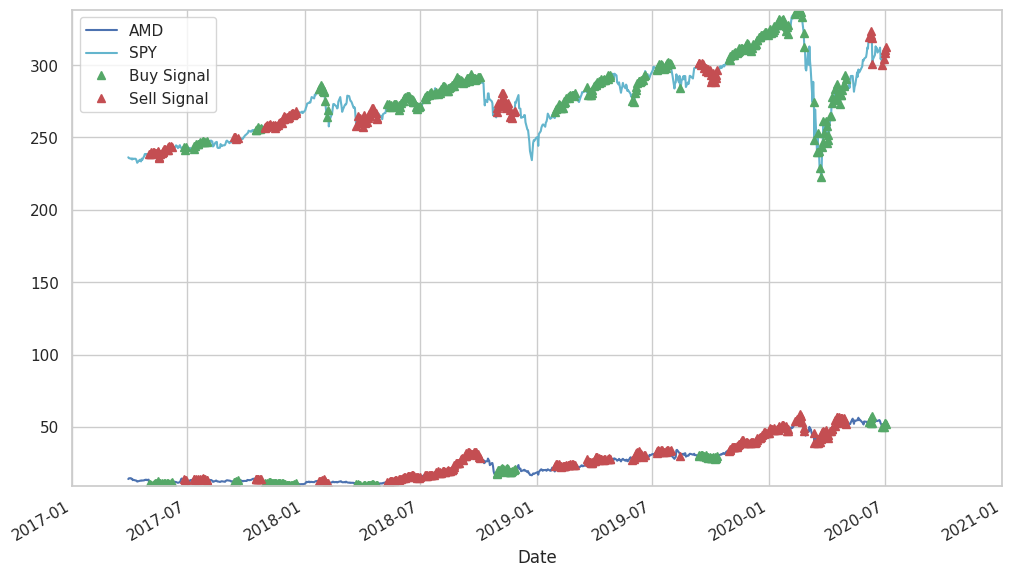

In [40]:
plt.figure(figsize=(12,7))
S1 = df['AMD'].iloc[:881]
S2 = df['SPY'].iloc[:881]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))

plt.xlim('2017-01-01', '2021-01-01')

plt.legend(['AMD', 'SPY', 'Buy Signal', 'Sell Signal'])
plt.show()

In [25]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2):

    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0

    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std

    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))


    return money

In [41]:
trade(df['AMD'].iloc[881:], df['SPY'].iloc[881:], 60, 5)

925.6386498442159

Below I have written a simple loop to create window lengths based on our PnL of training data to find the best window.

In [42]:
length_scores = [trade(df['AMD'].iloc[:1232],
                df['SPY'].iloc[:1232], l, 5)
                for l in range(255)]
best_length = np.argmax(length_scores)
print ('Best window length:', best_length)

Best window length: 124


We can compare this with the testing data and see that this window length is far from optimal. This is because our original choice for the window length probability overfit the sample data.

In [24]:
length_scores2 = [trade(df['AMD'].iloc[1232:],
                  df['SPY'].iloc[1232:],l,5)
                  for l in range(255)]
print (best_length, 'day window:', length_scores2[best_length])
# Find the best window length based on this dataset,
# and the returns using this window length
best_length2 = np.argmax(length_scores2)
print (best_length2, 'day window:', length_scores2[best_length2])

Streaming output truncated to the last 5000 lines.
Buying Ratio 7.105427357601002e-15 0.1706629935478097 33 -5.868581543087852
Buying Ratio 7.105427357601002e-15 0.1699647339749986 34 -6.03854627706285
Buying Ratio 7.105427357601002e-15 0.17094129813180683 35 -6.209487575194657
Buying Ratio 7.105427357601002e-15 0.17523237029753116 36 -6.384719945492189
Buying Ratio 7.105427357601002e-15 0.16773481930446824 37 -6.552454764796657
Buying Ratio 7.105427357601002e-15 0.16849911474237866 38 -6.720953879539036
Buying Ratio 7.105427357601002e-15 0.16588883447894276 39 -6.886842714017979
Buying Ratio 0.0 0.16611798196379227 40 -7.0529606959817706
Buying Ratio 0.0 0.16904861068774224 41 -7.222009306669513
Buying Ratio 0.0 0.1693643225780607 42 -7.391373629247574
Buying Ratio 0.0 0.1681109064959439 43 -7.559484535743517
Buying Ratio 0.0 0.16849072862385894 44 -7.727975264367377
Buying Ratio 0.0 0.16429437774483643 45 -7.892269642112213
Buying Ratio 0.0 0.16481138244051774 46 -8.05708102455273
Bu

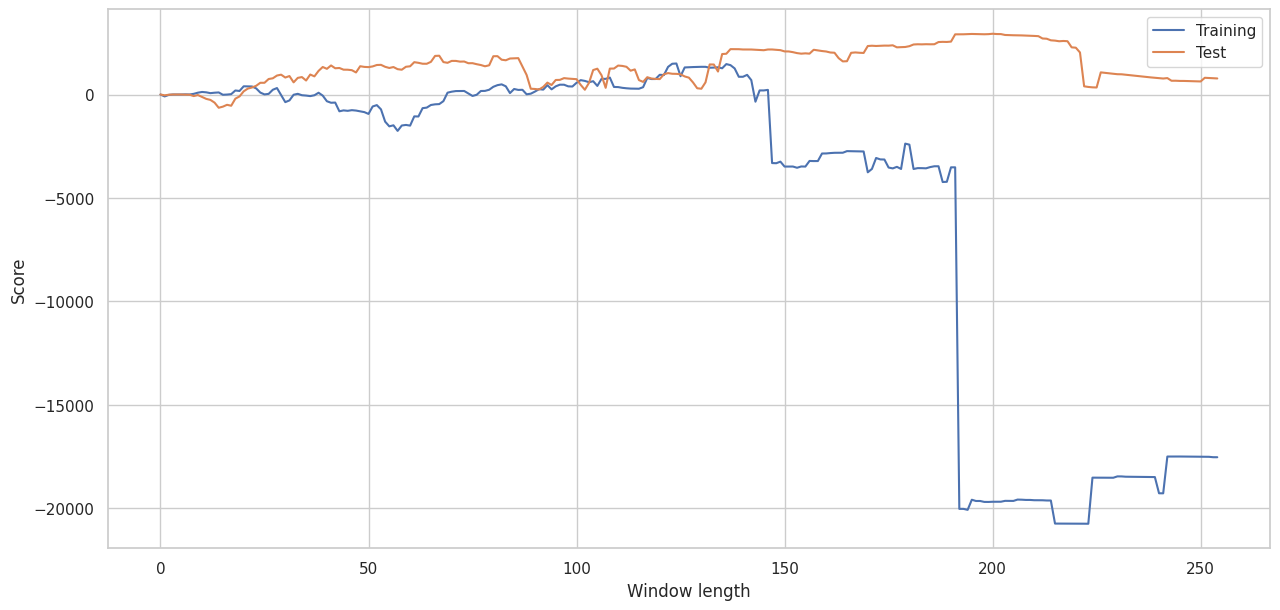

In [43]:
plt.figure(figsize=(15,7))
plt.plot(length_scores)
plt.plot(length_scores2)
plt.xlabel('Window length')
plt.ylabel('Score')
plt.legend(['Training', 'Test'])
plt.show()

Using windows of around 100 - 150 days is recommended